In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit

In [2]:
# Data from Curtis, example 4.3
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

orb = Orbit.from_vectors(Earth, r, v)

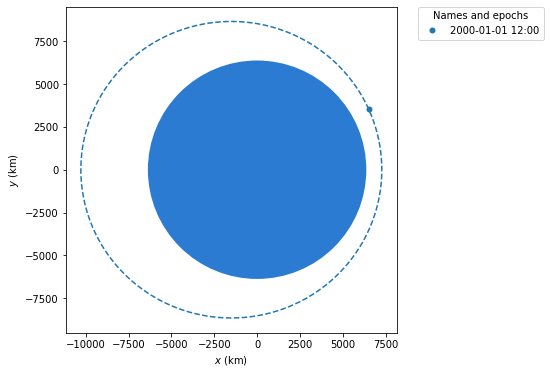

In [3]:
orb.plot()

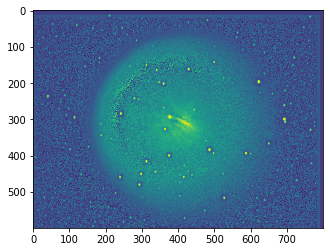

In [4]:
#reading in some jpeg images
im1 = plt.imread('../Data_CometHolmes/holmes-0001.jpg')
plt.imshow(im1)

In [5]:
(['altaz', 'barycentricmeanecliptic', 'barycentrictrueecliptic', 'cirs', 'custombarycentricecliptic', 'fk4', 
  'fk4noeterms', 'fk5', 'galactic', 'galacticlsr', 'galactocentric', 'gcrs', 'geocentricmeanecliptic', 
  'geocentrictrueecliptic', 'hcrs', 'heliocentriceclipticiau76', 'heliocentricmeanecliptic', 
  'heliocentrictrueecliptic', 'icrs', 'itrs', 'lsr', 'precessedgeocentric', 'supergalactic'])


['altaz',
 'barycentricmeanecliptic',
 'barycentrictrueecliptic',
 'cirs',
 'custombarycentricecliptic',
 'fk4',
 'fk4noeterms',
 'fk5',
 'galactic',
 'galacticlsr',
 'galactocentric',
 'gcrs',
 'geocentricmeanecliptic',
 'geocentrictrueecliptic',
 'hcrs',
 'heliocentriceclipticiau76',
 'heliocentricmeanecliptic',
 'heliocentrictrueecliptic',
 'icrs',
 'itrs',
 'lsr',
 'precessedgeocentric',
 'supergalactic']

In [6]:
ra = 60
dec = 54
spot_test = SkyCoord(ra,dec,unit="deg")
spot_test

<SkyCoord (ICRS): (ra, dec) in deg
    (60., 54.)>

In [10]:
test_pt = SkyCoord.from_pixel(600,800,world_coord,origin=0,mode='wcs')
test_pt

NameError: name 'world_coord' is not defined

In [35]:
sky_coords = []
from astropy.time import Time
time_test = Time(58362*u.d, format='jd')
for i in range(50,75):
    for j in range(44,60):
        sky_coords.append(SkyCoord(i,j,unit="deg", frame='gcrs', obstime = time_test))

In [27]:
#takes a plt.imread image, WCS object from .wcs file, eta (0,1), and point is a SkyCoord object
#deterimines if point is in the eta subimage of the image as defined in the paper
#HOW TO DETERMINE AREA OF IMAGE?????????
def subimage_contains(img, wcs_func, eta, point):
    
    #assigning variables to the image dimensions
    a,b = img.shape[:2]
    
    #variable assignments that have to do with determining whether the point is in the eta subimage
    r_eta = np.sqrt(eta)
    am = int(a*(1-r_eta)/2)
    ap = int(a*(1+r_eta)/2)
    bm = int(b*(1-r_eta)/2)
    bp = int(b*(1+r_eta)/2)
    
    #boolean values 
    Abool = point.contained_by(wcs_func, image = np.ones((b,am)))
    Bbool = point.contained_by(wcs_func, image = np.ones((bm,a)))
    Cbool = point.contained_by(wcs_func, image = np.ones((bp,ap)))
    
    
    #boolshit
    final_bool = (not Abool) and (not Bbool) and (Cbool)
    
    return final_bool

(388, 600, 3)
Footprint:  [[54.11638511 59.12547771]
 [74.88373659 51.78370838]
 [67.19103169 44.54491564]
 [48.47579783 50.65167573]]
False


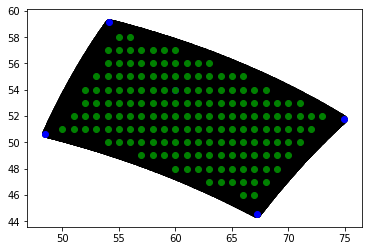

In [36]:
num_param = '0027'

image_array = plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(num_param))
print(image_array.shape)
image_shape = np.ones(image_array.shape[:2])
world_coord = wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(num_param))

#plt.imshow(image_array)
pixel_coords = np.ones((len(image_array)*len(image_array[0]), 2))
#loop through the array and make pixel coords at each point, might have to flip axes

foot_print = world_coord.calc_footprint(axes = [len(image_array),len(image_array[0])])
print("Footprint: ", foot_print)

    
#print(spot_test.contained_by(world_coord, image = image_shape[:400])) #how does the footprint work?
print(spot_test.contained_by(world_coord, image = np.ones((100,600))))

##CHOOSE COORDINATE SYSTEM THAT IS CORRECT, MIGHT BE LITTLE ERRORS IN THE CONTAINED_BY METHOD

##HOW TO DO SUBIMAGE DESCRIBED IN THE PAPER???
eta = 0.8
#r_eta = np.sqrt(eta)
#in_subimage = False
#a,b = image_array.shape[:2]
#am is "a minus" to denote the relevant values
#am = int(a*(1-r_eta)/2)
#ap = int(a*(1+r_eta)/2)
#bm = int(b*(1-r_eta)/2)
#bp = int(b*(1+r_eta)/2)

validRA = []
validDEC = []
for i in sky_coords:
    
    if subimage_contains(image_array, world_coord, eta, i):
        validRA.append(i.ra.degree)
        validDEC.append(i.dec.degree)


##LOOK AT SUBIMAGE DOCUMENTATION, try specifying image dimension in footprint_contains

for i in range(len(image_array)):
    for j in range(len(image_array[0])):
        index = i*len(image_array[0]) + j
        pixel_coords[index][0] = i
        pixel_coords[index][1] = j

trans_coords = np.transpose(world_coord.wcs_pix2world(pixel_coords, 0))
plt.scatter(trans_coords[0], trans_coords[1], color='k');
plt.scatter(np.transpose(foot_print)[0], np.transpose(foot_print)[1],color='b')
plt.scatter([spot_test.ra.degree],[spot_test.dec.degree],color='b')
plt.scatter(validRA,validDEC,color='g')

In [26]:
#the above result are the corners, starting with the bottom left and going clockwise, 
#points are in format (ra, dec)

In [29]:
#use this command to extract the information you need to define a RA and DEC rectangle in the sky
a = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-0001.wcs

SyntaxError: invalid syntax (<ipython-input-29-33c7eb7c5f98>, line 2)

In [28]:
a

['/bin/bash: /usr/local/astrometry/bin/wcsinfo: No such file or directory']

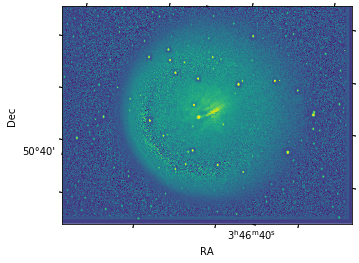

In [116]:
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
import astropy.units as u

#filename = get_pkg_data_filename('../Data_CometHolmes/holmes-0010.wcs')

#hdu = fits.open(filename)[0]
wcs = WCS('../Data_CometHolmes/holmes-0001.wcs')
test_im = plt.imread('../Data_CometHolmes/holmes-0001.jpg')
fig = plt.figure()
fig.add_subplot(111, projection=wcs)
plt.imshow(test_im, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
#plt.xlim([0,1000])
#plt.ylim([0,800]);

In [122]:
np.linspace(5,10,6)

array([ 5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
['p2030.20150509.G54.40-00.89.S.b2.00000',
'puppi_57292_J1935+18_3663_subs_0001',
'puppi_57303_J1935+18_3787_subs_0001',
'puppi_57311_J1935+18_3931_subs_0001',
'puppi_57312_J1935+18_3967_subs_0001',
'puppi_57313_J1935+18_4001_subs_0001',
'puppi_57315_J1935+18_4017_subs_0001',
'puppi_57317_J1935+18_4075_subs_0001',
'puppi_57320_J1935+18_4163_subs_0001',
'puppi_57330_J1935+18_4397_subs_0001',
'puppi_57341_J1935+18_4543_subs_0001',
'puppi_57362_J1935+18_4984_subs_0001',
'puppi_57403_J1935+18_5651_subs_0001']

In [ ]:
['p2030.20090423.G62.22-00.89.S.b1.00000.fits',
'puppi_56241_1952+25_1226_subs_0001.fits',
'puppi_56242_1952+25_1250_subs_0001.fits',
'puppi_56244_1952+25_1284_subs_0001.fits',
'puppi_56248_1952+25_1336_subs_0001.fits',
'puppi_56256_1952+25_1438_subs_0001.fits',
'puppi_56279_1952+25_1553_subs_0001.fits',
'puppi_56298_1952+25_1658_subs_0001.fits',
'puppi_56368_1952+25_0457_subs_0001.fits',
'puppi_56375_1952+25_0509_subs_0001.fits',
'puppi_56401_1952+25_0725_subs_0001.fits',
'puppi_56404_1952+25_0815_subs_0001.fits',
'puppi_56405_1952+25_0836_subs_0001.fits',
'puppi_56405_1952+25_0840_subs_0001.fits',
'puppi_56406_1952+25_0903_subs_0001.fits',
'puppi_56408_1952+25_0950_subs_0001.fits',
'puppi_56410_1952+25_0015_subs_0001.fits',
'puppi_56410_1952+25_0017_subs_0001.fits',
'puppi_56413_1952+25_0094_subs_0001.fits',
'puppi_56418_1952+25_0228_subs_0001.fits',
'puppi_56424_1952+25_313000072_subs_0001.fits',
'puppi_56436_1952+25_313000177_subs_0001.fits',
'puppi_56439_1952+25_313000265_subs_0001.fits',
'puppi_56464_1952+25_0102_subs_0001.fits',
'puppi_56477_1952+25_0254_subs_0001.fits',
'puppi_56495_1952+25_0413_subs_0001.fits',
'puppi_56518_1952+25_0810_subs_0001.fits',
'puppi_56524_J1952+2512_0978_subs_0001.fits',
'puppi_56555_J1952+2512_0253_subs_0001.fits',
'puppi_56742_J1952+2512_0486_subs_0001.fits',
'puppi_56746_J1952+2512_0556_subs_0001.fits',
'puppi_56771_J1952+2512_0926_subs_0001.fits',
'puppi_56799_J1952+2512_1309_subs_0001.fits',
'puppi_56828_J1952+2512_0291_subs_0001.fits',
'puppi_56857_J1952+2512_0270_subs_0001.fits',
'puppi_56885_J1952+2512_0668_subs_0001.fits',
'puppi_56947_J1952+2512_0469_subs_0001.fits',
'puppi_56976_J1952+2512_0853_subs_0001.fits',
'puppi_57001_J1952+2512_0128_subs_0001.fits']